In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('Data/datasheets_cleaned/2021_09_09.csv')

# Convert to GeoDataFrame and project to UTM
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['Longitude'], data['Latitude']),
    crs="EPSG:4326"  # WGS84
)
gdf = gdf.to_crs(epsg=32632)  # Convert to UTM Zone 32V (adjust zone if needed)
gdf['UTM_X'] = gdf.geometry.x
gdf['UTM_Y'] = gdf.geometry.y

print (gdf.head())

       KM   Latitude  Longitude  RX_HorizontalWearConsumption  \
0  335845  60.733325   7.121283                         -2.57   
1  335850  60.733354   7.121352                         -1.69   
2  335855  60.733383   7.121422                         -1.70   
3  335860  60.733414   7.121489                         -1.72   
4  335865  60.733445   7.121554                          0.09   

   LX_HorizontalWearConsumption  RX_VerticalWear  LX_VerticalWear  \
0                         -1.50            -1.01             0.84   
1                         -1.77            -1.01             2.82   
2                         -1.55            -1.01             2.79   
3                         -0.73            -1.01             2.56   
4                          0.00            -0.72            -0.82   

                         geometry          UTM_X         UTM_Y  
0  POINT (397546.839 6734549.955)  397546.838921  6.734550e+06  
1  POINT (397550.731 6734553.094)  397550.731141  6.734553e+06  

In [2]:

# Define curvature calculation function
def calculate_signed_curvature(points):
    """
    Calculate curvature with a sign to indicate direction (left or right).
    """
    curvatures = []
    epsilon = 1e-6  # Small value to avoid division by zero
    for i in range(1, len(points) - 1):
        p1, p2, p3 = points[i - 1], points[i], points[i + 1]
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3

        # Calculate determinant (area-based)
        det = (x1 * (y2 - y3) +
               x2 * (y3 - y1) +
               x3 * (y1 - y2))

        # Calculate distances between points
        a = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        b = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
        c = np.sqrt((x1 - x3)**2 + (y1 - y3)**2)

        if abs(det) < epsilon:
            curvatures.append(0)  # Treat as straight line
        else:
            # Calculate radius and curvature
            radius = (a * b * c) / (2 * abs(det))
            curvature = 1 / radius

            # Determine sign of curvature using cross product
            cross_product = (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)
            curvature *= np.sign(cross_product)  # Assign sign based on cross product

            curvatures.append(curvature)

    return [0] + curvatures + [0]  # Add padding for start and end

# Extract UTM coordinates as a list of tuples
original_points = list(zip(gdf['UTM_X'], gdf['UTM_Y']))

# Calculate signed curvature
gdf['Signed_Curvature'] = calculate_signed_curvature(original_points)


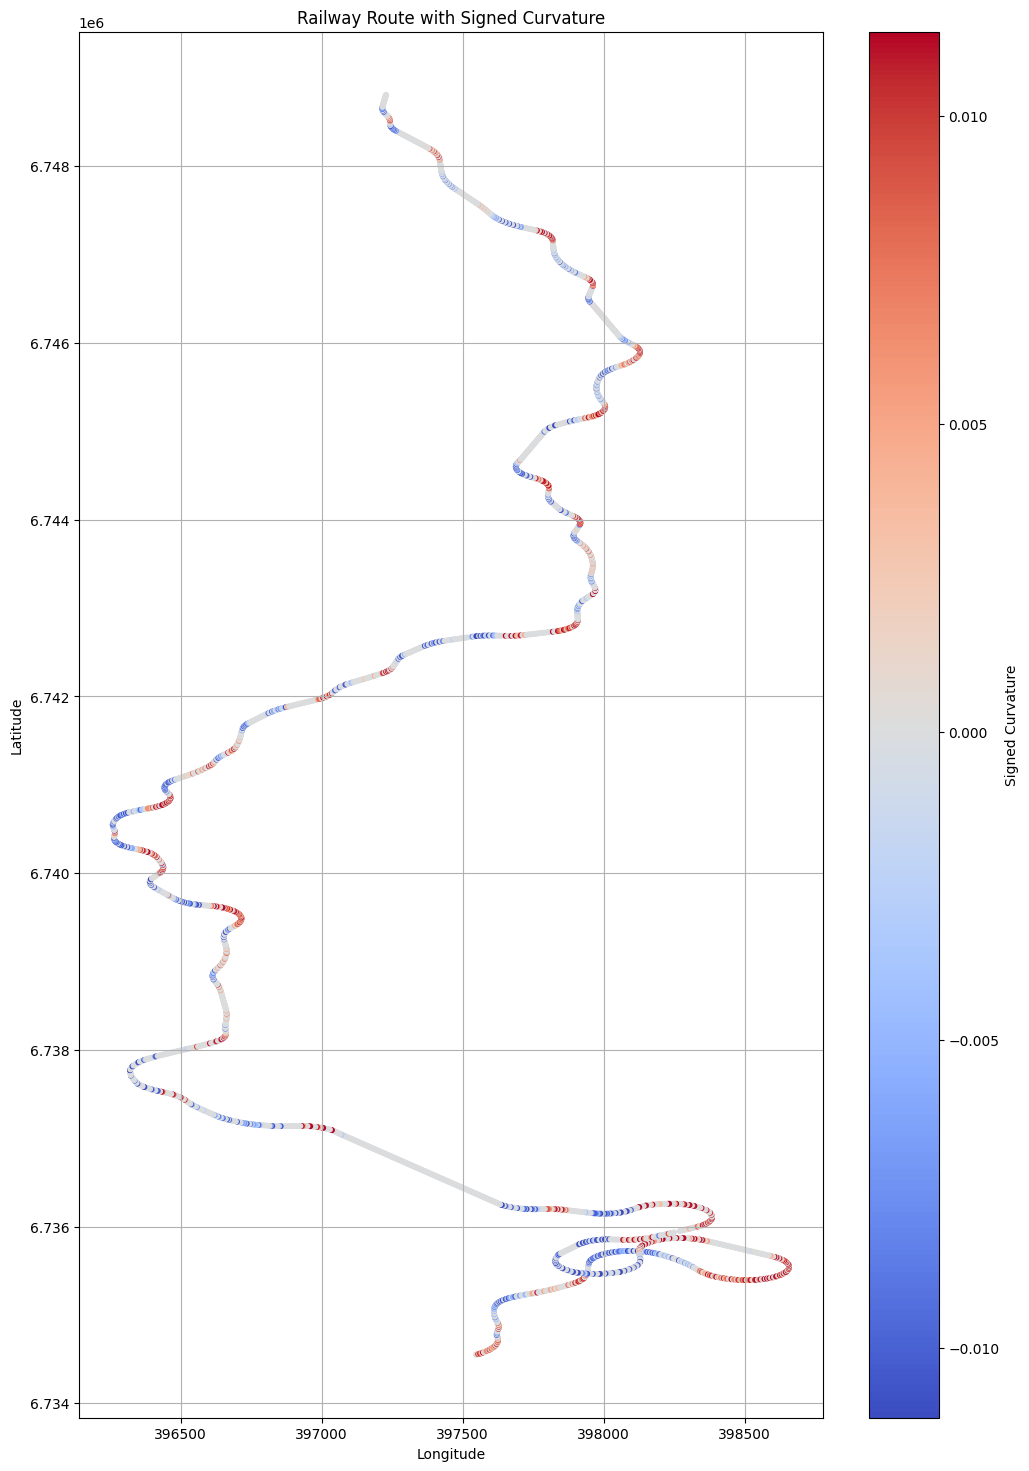

In [6]:
import numpy as np

# Calculate the 5th and 95th percentiles for Signed Curvature
vmin = np.percentile(gdf['Signed_Curvature'], 5)
vmax = np.percentile(gdf['Signed_Curvature'], 95)

# Plot the route with curvature, color-coded by the smoothed curvature values
plt.figure(figsize=(12, 18))
sc = plt.scatter(
    gdf['Longitude'], 
    gdf['Latitude'], 
    c=gdf['Signed_Curvature'], 
    cmap='coolwarm', 
    s=10, 
    vmin=vmin,  # Set minimum value for color scale
    vmax=vmax   # Set maximum value for color scale
)
plt.colorbar(sc, label='Signed Curvature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Railway Route with Signed Curvature')
plt.grid(True)
plt.show()


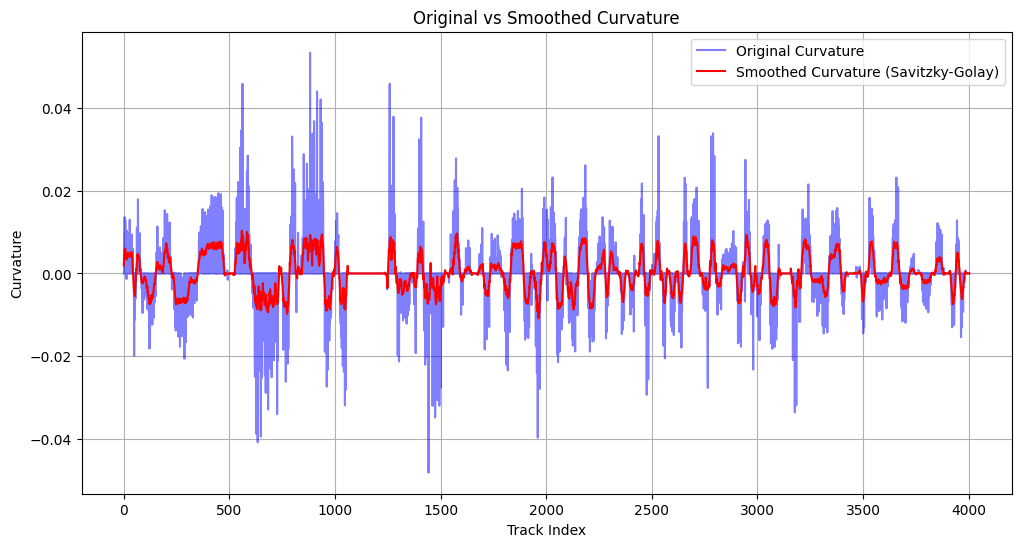

In [4]:


from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter to smooth the curvature values
# Adjust the window_length and polyorder based on your data characteristics
window_length = 21  # Must be odd and should be large enough to capture trends
polyorder = 3       # Polynomial degree for the fit

# Ensure the window length is smaller than the dataset length
if window_length > len(gdf['Signed_Curvature']):
    window_length = len(gdf['Signed_Curvature']) - (len(gdf['Signed_Curvature']) % 2) - 1

gdf['Smoothed_Curvature'] = savgol_filter(gdf['Signed_Curvature'], window_length=window_length, polyorder=polyorder)

# Plot the original and smoothed curvature
plt.figure(figsize=(12, 6))
plt.plot(gdf.index, gdf['Signed_Curvature'], label='Original Curvature', alpha=0.5, color='blue')
plt.plot(gdf.index, gdf['Smoothed_Curvature'], label='Smoothed Curvature (Savitzky-Golay)', color='red')
plt.xlabel('Track Index')
plt.ylabel('Curvature')
plt.title('Original vs Smoothed Curvature')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Save the smoothed curvature back to the GeoDataFrame for further analysis


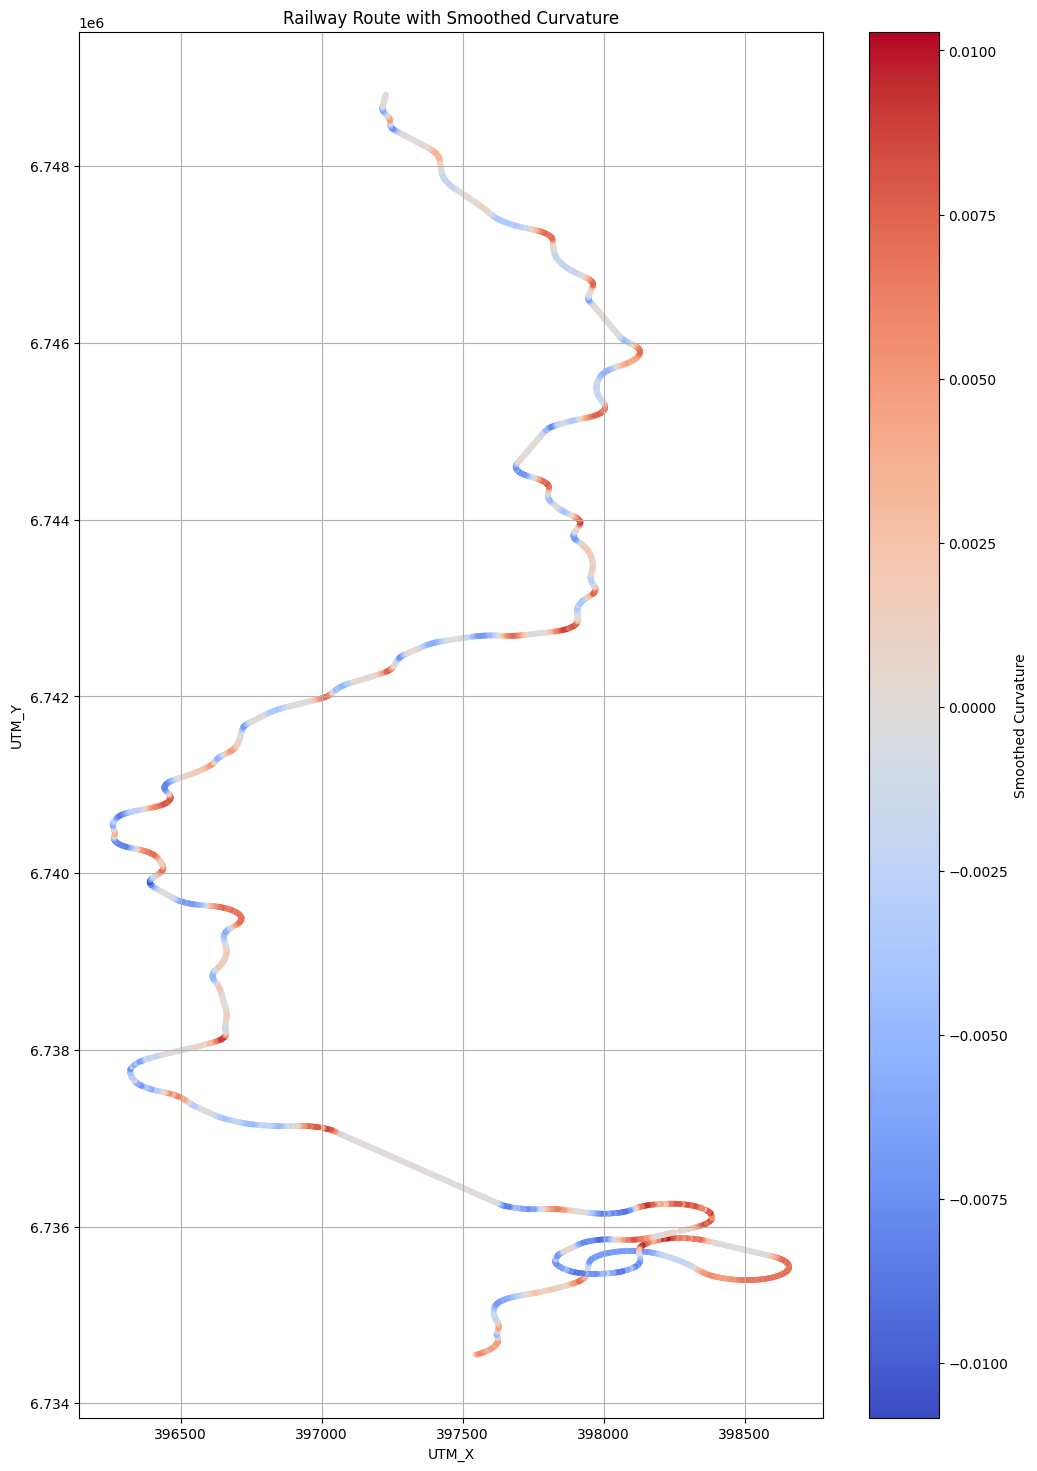

In [5]:
import matplotlib.pyplot as plt

# Plot the route with curvature, color-coded by the smoothed curvature values
plt.figure(figsize=(12, 18))
sc = plt.scatter(
    gdf['UTM_X'], 
    gdf['UTM_Y'], 
    c=gdf['Smoothed_Curvature'], 
    cmap='coolwarm', 
    s=10, 
    label='Smoothed Curvature'
)
plt.colorbar(sc, label='Smoothed Curvature')
plt.xlabel('UTM_X')
plt.ylabel('UTM_Y')
plt.title('Railway Route with Smoothed Curvature')
plt.grid(True)
plt.show()
